In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sys import path
path.append('..')
from statistical_clear_sky.algorithm.iterative_fitting import IterativeFitting
from statistical_clear_sky.solver_type import SolverType
from statistical_clear_sky.utilities.data_conversion import make_time_series
from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')
%matplotlib inline
PLOT_ARGS = {
    'linewidth': 1,
    'figsize': (12,8)
}
from time import time
from datetime import datetime
from os.path import expanduser
from scipy.interpolate import interp1d
from scipy.stats import kstest

In [3]:
def threshold(alpha, n1, n2):
    c1 = np.sqrt(-0.5 * np.log(alpha / 2.))
    c2 = np.sqrt((n1 + n2) * 1. / (n1 * n2))
    return c1 * c2

In [4]:
def reverseThreshold(D, n1, n2):
    c2 = np.sqrt((n1 + n2) * 1. / (n1 * n2))
    return 2 * np.exp(-2 * (D / c2)**2)

## S47 - 6 months of data

In [4]:
ti = time()
home = expanduser("~")
with open(home+'/.aws/cassandra_cluster') as f:
    cluster_ip = f.readline().strip('\n')
cluster = Cluster([cluster_ip])
session = cluster.connect('measurements')
cql = """
    select site, meas_name, ts, sensor, meas_val_f 
    from measurement_raw
    where site in ('TADHC1036570')
        and meas_name = 'ac_power';
"""
rows = session.execute(cql)
df = pd.DataFrame(list(rows), )
df.replace(-999999.0, np.NaN, inplace=True)
df = make_time_series(df, return_keys=False).fillna(0)
days = df.resample('D').max().index[1:-1]
start = days[0].strftime('%m/%d/%y')
end = days[-1].strftime('%m/%d/%y')
tf = time()
print(start, end)
print('data loading took {:.2f} seconds'.format(tf-ti))

04/10/15 10/19/18
data loading took 7.85 seconds


In [5]:
p = df.loc[start:end].values
power_signals_d = df.loc[start:end].values.reshape(288, -1, order='F')[:, :365//2]

In [6]:
power_signals_d.shape

(288, 182)

In [7]:
iterative_fitting = IterativeFitting(power_signals_d, rank_k=5, reserve_test_data=0.1, solver_type=SolverType.mosek)

In [8]:
iterative_fitting.test_days

array([  7,  10,  44,  48,  58,  72,  79, 106, 112, 120, 129, 135, 137,
       151, 155, 165, 176, 180])

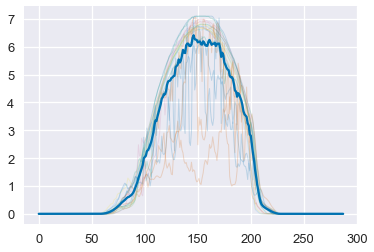

In [9]:
plt.plot(power_signals_d[:, iterative_fitting.test_days], linewidth=1, alpha=0.2)
plt.plot(np.average(power_signals_d[:, iterative_fitting.test_days], axis=1))
plt.show()

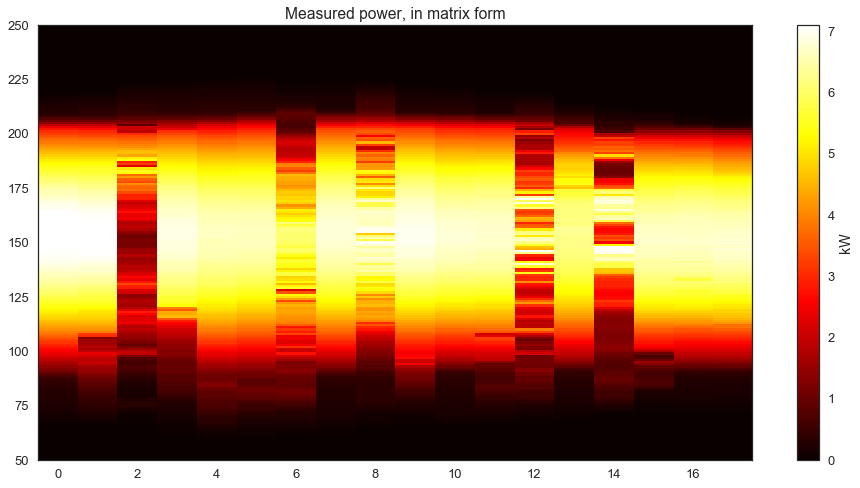

In [10]:
with sns.axes_style("white"):
    fig = plt.figure(figsize=(16,8))
    plt.imshow(iterative_fitting.power_signals_d[:, ics.test_days], cmap='hot', aspect='auto', interpolation='none')
    plt.colorbar(label='kW')
    plt.title('Measured power, in matrix form')
    plt.ylim(50, 250)

In [11]:
iterative_fitting.execute(mu_l=5e2, mu_r=1e3, tau=0.9, max_iteration=12)

starting at 326428.672 [650.8028531031717, 318.1322943972495, 325459.73696755094, 0]
iteration 1: 348.121 [309.344   9.324  29.453   0.   ]
iteration 2: 321.710 [283.003   7.831  30.875   0.   ]
iteration 3: 317.765 [277.434   9.215  31.116   0.   ]
iteration 4: 316.538 [275.275  10.145  31.118   0.   ]
iteration 5: 315.971 [274.414  10.483  31.074   0.   ]
iteration 6: 315.541 [274.04   10.629  30.872   0.   ]
iteration 7: 315.228 [273.815  10.77   30.642   0.   ]
Minimization complete in 0.57 minutes


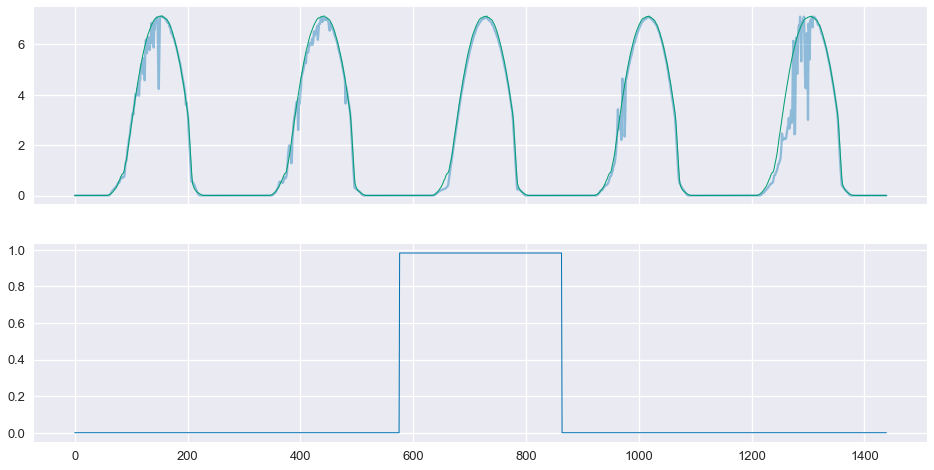

In [12]:
d1 = 20
d2 = D1+5
actual = p[d1*288:d2*288]
clearsky = ((iterative_fitting.clear_sky_signals()))[:, d1:d2].ravel(order='F')
fig, ax = plt.subplots(nrows=2, figsize=(16,8), sharex=True)
ax[0].plot(actual, alpha=0.4)
ax[0].plot(clearsky, linewidth=1)
ax[1].plot(np.repeat(iterative_fitting.weights[d1:d2], 288), linewidth=1)

In [13]:
clearsky = np.asarray(iterative_fitting.clear_sky_signals())

In [14]:
clearsky.shape

(288, 182)

In [15]:
ics.test_days
train_days = np.array(list(set(range(clearsky.shape[1])).difference(iterative_fitting.test_days)))

In [16]:
daytime = np.logical_not(np.isclose(iterative_fitting.power_signals_d, 0, atol=1e-3))
residuals_train = iterative_fitting.power_signals_d[:, train_days][daytime[:, train_days]] - iterative_fitting.clear_sky_signals()[:, train_days][daytime[:, train_days]]
residuals_test = iterative_fitting.power_signals_d[:, ics.test_days][daytime[:, ics.test_days]] - iterative_fitting.clear_sky_signals()[:, iterative_fitting.test_days][daytime[:, iterative_fitting.test_days]]

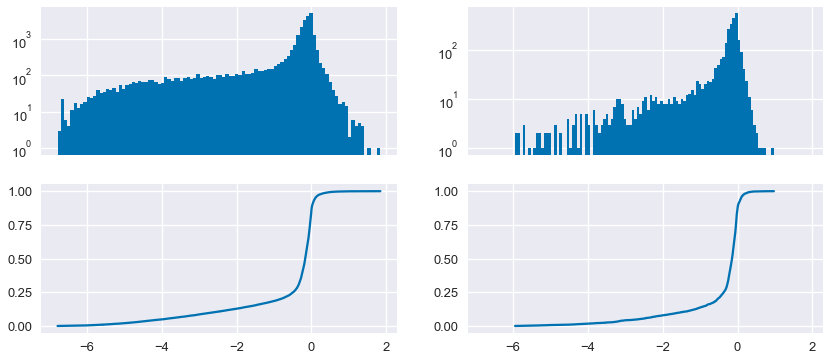

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 6), sharex=True)
ax[0, 0].set_yscale('log')
ax[0, 0].hist(residuals_train, bins=100)
ax[0, 1].set_yscale('log')
ax[0, 1].hist(residuals_test, bins=100)
ax[1, 0].plot(np.sort(residuals_train), np.linspace(0, 1, len(residuals_train), endpoint=False))
ax[1, 1].plot(np.sort(residuals_test), np.linspace(0, 1, len(residuals_test), endpoint=False))
plt.show()

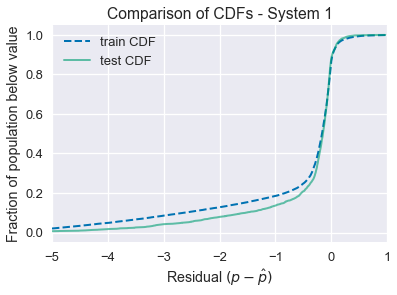

In [18]:
plt.plot(np.sort(residuals_train), np.linspace(0, 1, len(residuals_train), endpoint=False), linewidth=2, ls='--', label='train CDF')
plt.plot(np.sort(residuals_test), np.linspace(0, 1, len(residuals_test), endpoint=False), linewidth=2, alpha=0.6, label='test CDF')
plt.xlim(-5, 1)
plt.title('Comparison of CDFs - System 1')
plt.xlabel('Residual $(p - \\hat{p})$')
plt.ylabel('Fraction of population below value')
plt.legend(loc=2)

In [19]:
cdf = interp1d(np.r_[np.min(residuals_test), np.sort(residuals_train)[1:-1], np.max(residuals_test)], np.linspace(0, 1, len(residuals_train), endpoint=False))
#cdf = interp1d(np.sort(residuals_train), np.linspace(0, 1, len(residuals_train), endpoint=False))

In [20]:
stat, pval = kstest(residuals_test, cdf)
stat

0.05570716145717497

In [21]:
alpha = reverseThreshold(stat, len(residuals_train), len(residuals_test))
print('Probability of incorrectly rejecting null hypothesis: {:.2e}'.format(alpha))

Probability of incorrectly rejecting null hypothesis: 2.53e-07


## S07 - 3years of data

In [22]:
ti = time()
home = expanduser("~")
with open(home+'/.aws/cassandra_cluster') as f:
    cluster_ip = f.readline().strip('\n')
cluster = Cluster([cluster_ip])
session = cluster.connect('measurements')
cql = """
    select site, meas_name, ts, sensor, meas_val_f 
    from measurement_raw
    where site in ('TADBC1078041')
        and meas_name = 'ac_power';
"""
rows = session.execute(cql)
df = pd.DataFrame(list(rows), )
df.replace(-999999.0, np.NaN, inplace=True)
df = make_time_series(df, return_keys=False).fillna(0)
days = df.resample('D').max().index[1:-1]
start = days[0].strftime('%m/%d/%y')
end = days[-1].strftime('%m/%d/%y')
tf = time()
print(start, end)
print('data loading took {:.2f} seconds'.format(tf-ti))

04/25/15 10/19/18
data loading took 7.95 seconds


In [23]:
power_signals_d = df.loc[start:end].values.reshape(288, -1, order='F')
p = df.loc[start:end]
iterative_fitting = IterativeFitting(power_signals_d, rank_k=5, reserve_test_data=0.1, solver_type=SolverType.mosek)

In [24]:
iterative_fitting.test_days

array([  33,   40,   41,   45,   50,   52,   57,   78,  136,  137,  143,
        147,  150,  155,  160,  169,  181,  204,  208,  225,  252,  277,
        290,  291,  292,  296,  299,  313,  315,  336,  337,  340,  358,
        363,  375,  385,  386,  387,  402,  406,  408,  423,  440,  466,
        469,  480,  487,  507,  527,  533,  538,  544,  557,  566,  569,
        574,  575,  576,  582,  603,  628,  635,  642,  644,  652,  658,
        682,  702,  707,  718,  722,  730,  751,  752,  758,  760,  761,
        767,  798,  802,  821,  826,  830,  834,  837,  839,  849,  857,
        859,  870,  879,  881,  893,  899,  908,  918,  929,  941,  943,
        959,  960,  974,  979,  980,  986,  987, 1005, 1007, 1014, 1036,
       1049, 1051, 1071, 1086, 1087, 1090, 1132, 1156, 1159, 1196, 1197,
       1210, 1221, 1233, 1237, 1241, 1263])

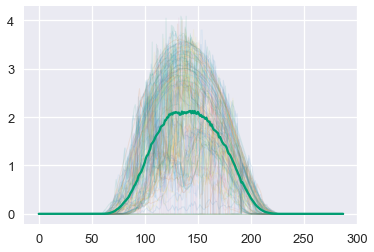

In [25]:
plt.plot(power_signals_d[:, iterative_fitting.test_days], linewidth=1, alpha=0.1)
plt.plot(np.average(power_signals_d[:, iterative_fitting.test_days], axis=1))
plt.show()

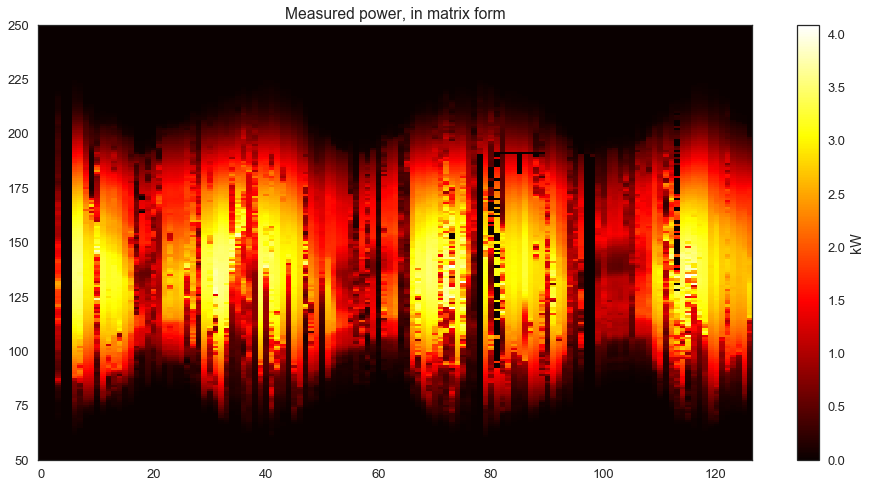

In [26]:
with sns.axes_style("white"):
    fig = plt.figure(figsize=(16,8))
    plt.imshow(iterative_fitting.power_signals_d[:, iterative_fitting.test_days], cmap='hot', interpolation='none', aspect='auto')
    plt.colorbar(label='kW')
    plt.title('Measured power, in matrix form')
    plt.ylim(50, 250)

In [27]:
iterative_fitting.execute(mu_l=5e2, mu_r=1e3, tau=0.9, max_iteration=8)

starting at 518418.633 [2496.508794309043, 123.75147107397191, 383074.39107082074, 132723.98131653498]
iteration 1: 1949.730 [1729.496   15.45   204.784    0.   ]
iteration 2: 1673.017 [1466.604   15.683  190.73     0.   ]
iteration 3: 1649.763 [1444.875   18.578  186.31     0.   ]
iteration 4: 1643.386 [1440.501   19.174  183.71     0.   ]
iteration 5: 1639.621 [1438.875   19.473  181.273    0.   ]
iteration 6: 1636.748 [1438.112   19.672  178.964    0.   ]
iteration 7: 1634.379 [1437.436   19.828  177.114    0.   ]
iteration 8: 1632.501 [1436.892   20.151  175.457    0.   ]
Reached iteration limit. Previous improvement: 0.11%
Minimization complete in 4.58 minutes


In [28]:
train_days = np.array(list(set(range(clearsky.shape[1])).difference(iterative_fitting.test_days)))

In [29]:
daytime = np.logical_not(np.isclose(iterative_fitting.power_signals_d, 0, atol=1e-3))
residuals_train = iterative_fitting.power_signals_d[:, train_days][daytime[:, train_days]] - iterative_fitting.clear_sky_signals()[:, train_days][daytime[:, train_days]]
residuals_test = iterative_fitting.power_signals_d[:, iterative_fitting.test_days][daytime[:, iterative_fitting.test_days]] - iterative_fitting.clear_sky_signals()[:, iterative_fitting.test_days][daytime[:, iterative_fitting.test_days]]

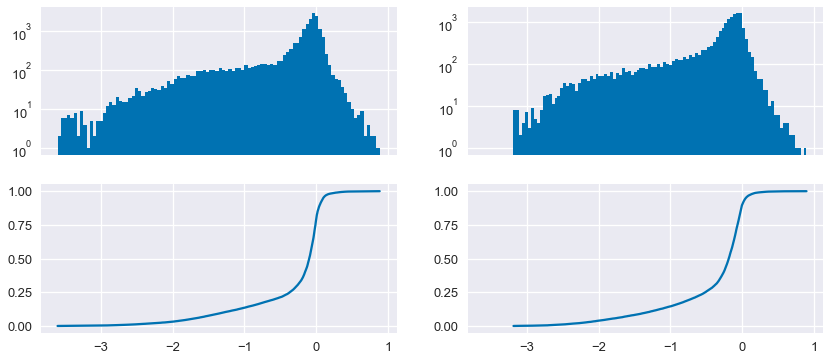

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 6), sharex=True)
ax[0, 0].set_yscale('log')
ax[0, 0].hist(residuals_train, bins=100)
ax[0, 1].set_yscale('log')
ax[0, 1].hist(residuals_test, bins=100)
ax[1, 0].plot(np.sort(residuals_train), np.linspace(0, 1, len(residuals_train), endpoint=False))
ax[1, 1].plot(np.sort(residuals_test), np.linspace(0, 1, len(residuals_test), endpoint=False))
plt.show()

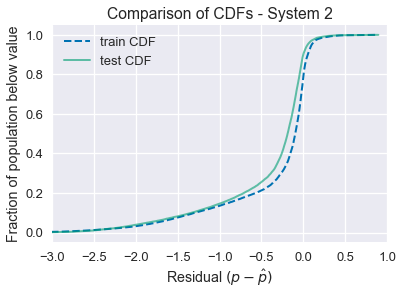

In [31]:
plt.plot(np.sort(residuals_train), np.linspace(0, 1, len(residuals_train), endpoint=False), linewidth=2, ls='--', label='train CDF')
plt.plot(np.sort(residuals_test), np.linspace(0, 1, len(residuals_test), endpoint=False), linewidth=2, alpha=0.6, label='test CDF')
plt.xlim(-3, 1)
plt.title('Comparison of CDFs - System 2')
plt.xlabel('Residual $(p - \\hat{p})$')
plt.ylabel('Fraction of population below value')
plt.legend(loc=2)

In [32]:
cdf = interp1d(np.r_[np.min(residuals_test), np.sort(residuals_train)[1:-1], np.max(residuals_test)], np.linspace(0, 1, len(residuals_train), endpoint=False))
#cdf = interp1d(np.sort(residuals_train), np.linspace(0, 1, len(residuals_train), endpoint=False))

In [33]:
stat, pval = kstest(residuals_test, cdf)
stat

0.18415019227589668

In [34]:
alpha = reverseThreshold(stat, len(residuals_train), len(residuals_test))
print('Probability of incorrectly rejecting null hypothesis: {:.2e}'.format(alpha))

Probability of incorrectly rejecting null hypothesis: 5.54e-264


# ERE Data - 1 Year

In [35]:
data = np.load('/Users/bennetmeyers/Documents/Data/collab/Huang_2017_data.npy')
p = data.ravel(order='F')

In [36]:
iterative_fitting = IterativeFitting(data, rank_k=5, reserve_test_data=0.1, solver_type=SolverType.mosek)

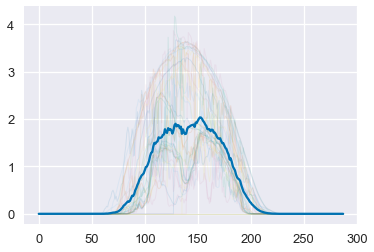

In [37]:
plt.plot(power_signals_d[:, iterative_fitting.test_days], linewidth=1, alpha=0.1)
plt.plot(np.average(power_signals_d[:, iterative_fitting.test_days], axis=1))
plt.show()

In [38]:
iterative_fitting.execute(mu_l=1e4, mu_r=5e3, tau=0.9, max_iteration=10)

starting at 18966408.683 [24481.09825041786, 5264.080113096101, 18936663.504533302, 0]
iteration 1: 16698.455 [13664.494    27.893  3006.069     0.   ]
iteration 2: 14178.524 [11269.964    60.729  2847.831     0.   ]
iteration 3: 13830.598 [10905.525    75.333  2849.74      0.   ]
iteration 4: 13743.050 [10811.936    77.491  2853.623     0.   ]
iteration 5: 13691.659 [10750.482    78.526  2862.651     0.   ]
iteration 6: 13652.129 [10701.109    79.554  2871.466     0.   ]
iteration 7: 13617.577 [10659.763    80.066  2877.748     0.   ]
iteration 8: 13585.018 [10622.6      80.615  2881.803     0.   ]
iteration 9: 13552.291 [10586.343    79.802  2886.146     0.   ]
iteration 10: 13521.380 [10556.696    78.486  2886.198     0.   ]
Reached iteration limit. Previous improvement: 0.23%
Minimization complete in 7.35 minutes


In [39]:
train_days = np.array(list(set(range(clearsky.shape[1])).difference(iterative_fitting.test_days)))

In [40]:
daytime = iterative_fitting.power_signals_d >= 1e-3
residuals_train = iterative_fitting.power_signals_d[:, train_days][daytime[:, train_days]] - iterative_fitting.clear_sky_signals()[:, train_days][daytime[:, train_days]]
residuals_test = iterative_fitting.power_signals_d[:, iterative_fitting.test_days][daytime[:, iterative_fitting.test_days]] - iterative_fitting.clear_sky_signals()[:, iterative_fitting.test_days][daytime[:, iterative_fitting.test_days]]

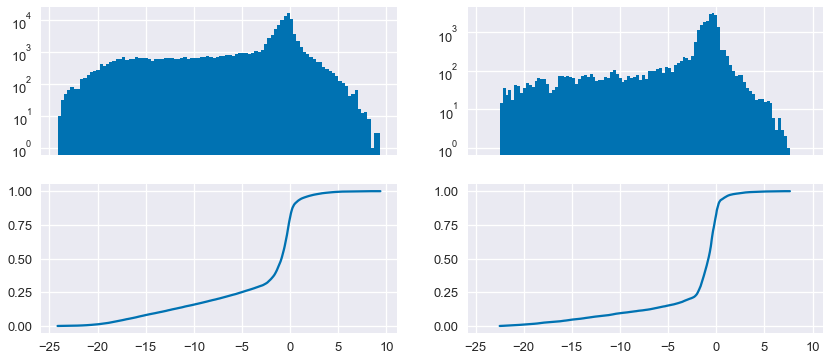

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 6), sharex=True)
ax[0, 0].set_yscale('log')
ax[0, 0].hist(residuals_train, bins=100)
ax[0, 1].set_yscale('log')
ax[0, 1].hist(residuals_test, bins=100)
ax[1, 0].plot(np.sort(residuals_train), np.linspace(0, 1, len(residuals_train), endpoint=False))
ax[1, 1].plot(np.sort(residuals_test), np.linspace(0, 1, len(residuals_test), endpoint=False))
plt.show()

In [42]:
cdf = interp1d(np.r_[np.min(residuals_test), np.sort(residuals_train)[1:-1], np.max(residuals_test)], np.linspace(0, 1, len(residuals_train), endpoint=False))
#cdf = interp1d(np.sort(residuals_train), np.linspace(0, 1, len(residuals_train), endpoint=False))

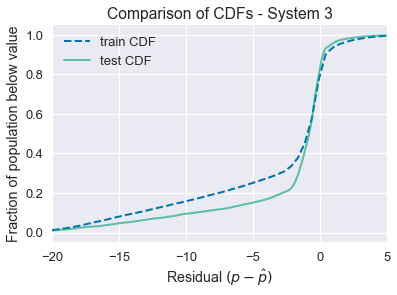

In [43]:
plt.plot(np.linspace(-20,5), cdf(np.linspace(-20,5)), linewidth=2, ls='--', label='train CDF')
plt.plot(np.sort(residuals_test), np.linspace(0, 1, len(residuals_test), endpoint=False), linewidth=2, alpha=0.6, label='test CDF')
plt.xlim(-20, 5)
plt.title('Comparison of CDFs - System 3')
plt.xlabel('Residual $(p - \\hat{p})$')
plt.ylabel('Fraction of population below value')
plt.legend(loc=2)

In [44]:
stat, pval = kstest(residuals_test, cdf)
stat

0.11130838116413094

In [45]:
alpha = reverseThreshold(stat, len(residuals_train), len(residuals_test))
print('Probability of incorrectly rejecting null hypothesis: {:.2e}'.format(alpha))

Probability of incorrectly rejecting null hypothesis: 1.33e-217
